## Create a classification of URLs

For project analyzing the evaluative content of quotes vs. non-quotes.

This notebook reads in the full CBC csv (in "CBC_input") and counts the number of:

* types of things immediately after: http://cbc.ca/ or http://www.cbc.ca/ or https://cbc.ca/ or https://www.cbc.ca/
* then, types of things immediately after that first / but before the last one

For instance, in the first case, we get categories like "books", "news", or "radio":

```
http://cbc.ca/books/the-great-beyond-by-léa-murawiec-translated-by-aleshia-jensen-1.6948864
http://www.cbc.ca/news/canada/nova-scotia/hurricane-franklin-powerful-surf-atlantic-canada-1.6950427
http://www.cbc.ca/radio/frontburner/as-fires-burn-n-w-t-s-premier-calls-out-ottawa-1.6951393
https://www.cbc.ca/sports/the-buzzer-newsletter-world-athletics-championships-day-6-preview-1.6945499
https://cbc.ca/radio/asithappens/pink-floyd-brain-scans-1.6939698

```

In the second, we get types of radio programs (as in "frontburner" above), but also types of news and other first-level categories:

```
http://www.cbc.ca/news/climate/northwest-territories-wildfires-1.6939337
https://www.cbc.ca/sports/tennis/tennis-dc-open-handshake-warning-1.6923907

```

\* 2024-11-13 edit: This notebook now uses the xlsx files from "CBC_sentiment_output" for consistency and ease of access

In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import ast
from ast import literal_eval
import os
import glob
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This needs to be done on the sentiment_output dirs, can be done on the quotes tab (url column).

## Redoing Information Extraction with Updated Dataframes

### Reading Excel files from Sentiment Output

In [3]:
path = r'C:/Maite/MOD/projects/Monika_Bednarek/Evaluation_quotes/Data/CBC_sentiment_output'

all_months = glob.glob(path + '/2023*.xlsx')
months_qt = []
months_nqt = []
for filename in all_months:
  temp_qt_df = pd.read_excel(filename, sheet_name='quotes', usecols=['text_name', 'compound', 'url'])
  temp_nqt_df = pd.read_excel(filename, sheet_name='non_quotes', usecols=['text_name', 'compound'])

  months_qt.append(temp_qt_df)
  months_nqt.append(temp_nqt_df)

quotes_df = pd.concat(months_qt, axis=0, ignore_index=True)
non_quotes_df = pd.concat(months_nqt, axis=0, ignore_index=True)

In [4]:
quotes_df.head()

,text_name,compound,url
0,63d2f449f642cd4562e2dafd,0.9422,https://www.cbc.ca/news/canada/windsor/detroit...
1,63baa544f642cd45622e5e52,0.8547,https://www.cbc.ca/news/world/china-borders-op...
2,63c5d969f642cd456280a6c3,0.8883,https://www.cbc.ca/news/world/martin-luther-ki...
3,63bfcf7af642cd456253f104,0.9663,https://www.cbc.ca/news/politics/ukraine-russi...
4,63d2a6eaf642cd4562e0acd0,-0.4939,https://www.cbc.ca/news/canada/toronto/toronto...


In [5]:
non_quotes_df.head()

,text_name,compound
0,63d2f449f642cd4562e2dafd,-0.4019
1,63baa544f642cd45622e5e52,0.9835
2,63c5d969f642cd456280a6c3,0.9886
3,63bfcf7af642cd456253f104,-0.8118
4,63d2a6eaf642cd4562e0acd0,-0.9728


In [6]:
num_articles = len(quotes_df)
num_articles

48701

In [7]:
# sanity check: same number of articles in non_quotes
len(non_quotes_df)

48701

In [8]:
# merge dataframes on text name
months_df = pd.merge(quotes_df, non_quotes_df, on=['text_name'], suffixes=('_quotes', '_non_quotes'))

print(months_df.head())
print(len(months_df))

                  text_name  compound_quotes  \
0  63d2f449f642cd4562e2dafd           0.9422   
1  63baa544f642cd45622e5e52           0.8547   
2  63c5d969f642cd456280a6c3           0.8883   
3  63bfcf7af642cd456253f104           0.9663   
4  63d2a6eaf642cd4562e0acd0          -0.4939   

                                                 url  compound_non_quotes  
0  https://www.cbc.ca/news/canada/windsor/detroit...              -0.4019  
1  https://www.cbc.ca/news/world/china-borders-op...               0.9835  
2  https://www.cbc.ca/news/world/martin-luther-ki...               0.9886  
3  https://www.cbc.ca/news/politics/ukraine-russi...              -0.8118  
4  https://www.cbc.ca/news/canada/toronto/toronto...              -0.9728  
48701


In [9]:
# rearrange columns to be more legible
headers = ['text_name', 'compound_quotes', 'compound_non_quotes', 'url']
months_df = months_df.reindex(columns=headers)

In [10]:
months_df.head()

,text_name,compound_quotes,compound_non_quotes,url
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...
1,63baa544f642cd45622e5e52,0.8547,0.9835,https://www.cbc.ca/news/world/china-borders-op...
2,63c5d969f642cd456280a6c3,0.8883,0.9886,https://www.cbc.ca/news/world/martin-luther-ki...
3,63bfcf7af642cd456253f104,0.9663,-0.8118,https://www.cbc.ca/news/politics/ukraine-russi...
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...


### Extracting First Segment: High Level Category
This only looks at the stuff right after 'cbc.ca' - generally "sports", "arts", "news". Since quotes and non_quotes sheets have the same articles and thus identical urls, we will do all url classification/analysis with the quotes_df.

In [11]:
months_df['first_segment'] = months_df['url'].str.extract(r'cbc\.ca/([^/]+)')

# count occurrences of unique segments
segment_counts = months_df['first_segment'].value_counts()

# display the counts
print("Counts for the first segment:\n", months_df['first_segment'].value_counts())

Counts for the first segment:
 news                 42979
sports                2768
radio                 1265
arts                   610
books                  314
music                  240
kidsnews               136
life                   129
documentaries          100
television              92
archives                39
newsletter_static       18
comedy                   9
indspire                 1
media                    1
Name: first_segment, dtype: int64


In [69]:
# export to csv
fp = '/content/drive/My Drive/evaluation_quotes/CSVs/URL_first_category.csv'
segment_counts.reset_index().to_csv(fp, index=False)

In [12]:
# count occurrences of each unique first segment
first_segment_counts = months_df['first_segment'].value_counts()

# calculate the total count
first_total_counts = first_segment_counts.sum()

print("Total count across all first segments: ", first_total_counts)
print("Total number of articles: ", num_articles)

Total count across all first segments:  48701
Total number of articles:  48701


In [13]:
months_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...,news
1,63baa544f642cd45622e5e52,0.8547,0.9835,https://www.cbc.ca/news/world/china-borders-op...,news
2,63c5d969f642cd456280a6c3,0.8883,0.9886,https://www.cbc.ca/news/world/martin-luther-ki...,news
3,63bfcf7af642cd456253f104,0.9663,-0.8118,https://www.cbc.ca/news/politics/ukraine-russi...,news
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...,news


### Extracting Last Segment: News Category
This looks at the subcategories for articles classified under "cbc.ca/news/". We want to figure out what are the most common subcategories under 'news'.

First we extract the last segment, i.e. the last level of categorization before the article title.

In [14]:
months_df['last_segment'] = months_df['url'].str.extract(r'cbc\.ca/[^/]+/([^/]+)')

# count occurrences of each unique last segment
last_segment_counts = months_df['last_segment'].value_counts()

# display the counts
print("Counts for the last segment:\n", last_segment_counts)

Counts for the last segment:
 canada                                                                                               37179
world                                                                                                 2012
politics                                                                                              1681
business                                                                                               640
olympics                                                                                               605
                                                                                                     ...  
canada-bermuda-cricket-mens-t20-americas-world-cup-qualifier-final-1.6990412                             1
spirit-muchmusic-still-alive-doc-premiere-with-vjs-1.6977287                                             1
the-man-who-stole-einstein-s-brain-hot-docs-interview-carolyn-abraham-michelle-shephard-1.6831222        1
nationa

In [15]:
# count occurrences of each unique last segment
last_segment_counts = months_df['last_segment'].value_counts()

# calculate the total count
last_total_counts = last_segment_counts.sum()

print("Total count across all last segments: ", last_total_counts) # we lost an article here?? how?? where??
print("Total number of articles: ", num_articles)

Total count across all last segments:  48700
Total number of articles:  48701


In [16]:
# filter the df so it is only news
news_df = months_df[months_df['first_segment'] == 'news']

In [17]:
news_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...,news,canada
1,63baa544f642cd45622e5e52,0.8547,0.9835,https://www.cbc.ca/news/world/china-borders-op...,news,world
2,63c5d969f642cd456280a6c3,0.8883,0.9886,https://www.cbc.ca/news/world/martin-luther-ki...,news,world
3,63bfcf7af642cd456253f104,0.9663,-0.8118,https://www.cbc.ca/news/politics/ukraine-russi...,news,politics
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...,news,canada


In [18]:
# count occurrences of each unique last segment
news_type_counts = news_df['last_segment'].value_counts()

# display the counts
print("Counts for the news types:\n", news_type_counts)

Counts for the news types:
 canada                                                 37179
world                                                   2012
politics                                                1681
business                                                 640
entertainment                                            512
                                                       ...  
montreal-bagel-uk-1.6849133                                1
former-caf-interpreter-arrest-afghanistan-1.7047195        1
ttc-halloween-subway-changes-1.7010403                     1
wage-theft-ontario-workers-1.6913090                       1
hong-kong-china-national-security-law-1.6890220            1
Name: last_segment, Length: 76, dtype: int64


In [70]:
# export to csv
fp = '/content/drive/My Drive/evaluation_quotes/CSVs/URL_news_type.csv'
news_type_counts.reset_index().to_csv(fp, index=False)

### Looking at subtypes of news under Canada

In [19]:
news_canada_df = news_df[news_df['last_segment'] == 'canada']

In [20]:
news_canada_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...,news,canada
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...,news,canada
6,63c4829bf642cd45627700ff,-0.3612,-0.8979,https://www.cbc.ca/news/canada/manitoba/winnip...,news,canada
7,63cc0137f642cd4562aeb9c1,0.9147,0.7903,https://www.cbc.ca/news/canada/british-columbi...,news,canada
8,63b96f99f642cd456226358d,0.9845,0.7783,https://www.cbc.ca/news/canada/british-columbi...,news,canada


In [21]:
news_canada_df['news_canada_type'] = news_canada_df['url'].str.extract(r'cbc\.ca/news/canada/([^/]+)')

# count occurrences of each unique segment
news_canada_counts = news_canada_df['news_canada_type'].value_counts()

# display the counts
print("Counts for the first news canada segment:\n", news_canada_df['news_canada_type'].value_counts())

Counts for the first news canada segment:
 british-columbia                                                            3843
manitoba                                                                    3445
nova-scotia                                                                 2764
toronto                                                                     2436
ottawa                                                                      2286
                                                                            ... 
psac-strike-cra-passports-canada-workers-labour-action-trudeau-1.6815288       1
pride-flags-political-debates-1.6837143                                        1
short-film-face-off-season-16-films-announced-1.6855661                        1
coronation-ceremony-processions-1.6829168                                      1
alberta-charges-carbon-offset-firm-1.6903889                                   1
Name: news_canada_type, Length: 409, dtype: int64


<ipython-input-21-8ef4e84cff6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_canada_df['news_canada_type'] = news_canada_df['url'].str.extract(r'cbc\.ca/news/canada/([^/]+)')


## URL Analysis
Want to create six dataframes with the following categories:
* sports_df: all urls from the sports category, as filtered from months_df
* news_df: all urls from the news category, as filtered from months_df (this df was already created in the previous section)
* arts_df: all urls from the arts category, as filtered from months_df

And the following subcategories:
* news_canada_df: all urls from the canada subcategory, as filtered from news_df (this df was already created in the previous section)
* news_world_df: all urls from the world subcategory, as filtered from news_df
* news_politics_df: all urls from the politics subcategory, as filtered from news_df

For each df, we want to take the average of
* all positive compound scores from quotes
* all negative compound scores from quotes
* all positive compound scores from non_quotes
* all negative compound scores from non_quotes

### Create dataframes

In [22]:
# create new dataframes
# remember: we already have news_df and news_canada_df
sports_df = months_df[months_df['first_segment'] == 'sports']
arts_df = months_df[months_df['first_segment'] == 'arts']
news_world_df = news_df[news_df['last_segment'] == 'world']
news_politics_df = news_df[news_df['last_segment'] == 'politics']

In [23]:
news_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...,news,canada
1,63baa544f642cd45622e5e52,0.8547,0.9835,https://www.cbc.ca/news/world/china-borders-op...,news,world
2,63c5d969f642cd456280a6c3,0.8883,0.9886,https://www.cbc.ca/news/world/martin-luther-ki...,news,world
3,63bfcf7af642cd456253f104,0.9663,-0.8118,https://www.cbc.ca/news/politics/ukraine-russi...,news,politics
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...,news,canada


In [24]:
sports_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
5,63c763acf642cd45628ba09b,0.9824,0.6169,https://www.cbc.ca/sports/tennis/australian-op...,sports,tennis
11,63b6f66ff642cd456215195c,0.9442,0.5423,https://www.cbc.ca/sports/football/nfl/buffalo...,sports,football
30,63c97a3ef642cd45629bdaab,0.9588,0.8750,https://www.cbc.ca/sports/hockey/hockey-canada...,sports,hockey
35,63d67ee5f642cd4562fd6778,0.8766,0.5589,https://www.cbc.ca/sports/olympics/winter/alpi...,sports,olympics
41,63d5263af642cd4562f3e2e1,0.9443,0.9934,https://www.cbc.ca/sports/olympics/winter/alpi...,sports,olympics


In [25]:
arts_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
31,63d19406f642cd4562d7fa64,0.0000,0.9985,http://www.cbc.ca/arts/why-sex-and-the-city-is...,arts,why-sex-and-the-city-is-actually-the-ultimate-...
132,63bc2f44f642cd456238cd16,0.9555,-0.8781,https://www.cbc.ca/arts/stuff-the-british-stol...,arts,stuff-the-british-stole-host-marc-fennell-want...
169,63e537f8f642cd45626c919d,0.5562,0.9872,https://www.cbc.ca/arts/how-chase-joynt-is-ima...,arts,how-chase-joynt-is-imagining-new-trans-worlds-...
343,63e3e67bf642cd45626290cc,0.9976,0.9967,https://www.cbc.ca/arts/hannah-moscovitch-inte...,arts,hannah-moscovitch-interview-with-the-vampire-f...
409,63c82f91f642cd4562923fe1,0.2263,0.9999,http://www.cbc.ca/arts/2023-oscars-95th-academ...,arts,2023-oscars-95th-academy-awards-nominations-ho...


In [26]:
news_canada_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment,news_canada_type
0,63d2f449f642cd4562e2dafd,0.9422,-0.4019,https://www.cbc.ca/news/canada/windsor/detroit...,news,canada,windsor
4,63d2a6eaf642cd4562e0acd0,-0.4939,-0.9728,https://www.cbc.ca/news/canada/toronto/toronto...,news,canada,toronto
6,63c4829bf642cd45627700ff,-0.3612,-0.8979,https://www.cbc.ca/news/canada/manitoba/winnip...,news,canada,manitoba
7,63cc0137f642cd4562aeb9c1,0.9147,0.7903,https://www.cbc.ca/news/canada/british-columbi...,news,canada,british-columbia
8,63b96f99f642cd456226358d,0.9845,0.7783,https://www.cbc.ca/news/canada/british-columbi...,news,canada,british-columbia


In [27]:
news_world_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
1,63baa544f642cd45622e5e52,0.8547,0.9835,https://www.cbc.ca/news/world/china-borders-op...,news,world
2,63c5d969f642cd456280a6c3,0.8883,0.9886,https://www.cbc.ca/news/world/martin-luther-ki...,news,world
14,63c28719f642cd456268c042,-0.9923,-0.9975,https://www.cbc.ca/news/world/iran-british-exe...,news,world
40,63c5e82ef642cd4562810bd2,-0.5859,-0.9802,https://www.cbc.ca/news/world/california-major...,news,world
74,63d70406f642cd45620110cb,-0.9979,-0.9974,https://www.cbc.ca/news/world/ukraine-russia-k...,news,world


In [28]:
news_politics_df.head()

,text_name,compound_quotes,compound_non_quotes,url,first_segment,last_segment
3,63bfcf7af642cd456253f104,0.9663,-0.8118,https://www.cbc.ca/news/politics/ukraine-russi...,news,politics
65,63ccfd88f642cd4562b57f9e,0.9313,-0.9578,https://www.cbc.ca/news/politics/sweden-foreig...,news,politics
73,63d63804f642cd4562fb7d58,-0.9939,-0.9981,https://www.cbc.ca/news/politics/kirsty-duncan...,news,politics
163,63c7167af642cd456289c4d3,0.9944,0.9968,https://www.cbc.ca/news/politics/poilievre-que...,news,politics
259,63ccfd7af642cd4562b57d3f,0.7103,-0.9223,https://www.cbc.ca/news/politics/advocates-cta...,news,politics


### Sentiment Analysis on URLs

In [29]:
# helper function for creating the summary table
# where df is the relevant category's dataframe
def get_sentiment(df):
  row = []

  # average of positive and negative quote scores
  row.append(df['compound_quotes'][df['compound_quotes'] > 0].mean())
  row.append(df['compound_quotes'][df['compound_quotes'] < 0].mean())

  # average of positive and negative non_quote scores
  row.append(df['compound_non_quotes'][df['compound_non_quotes'] > 0].mean())
  row.append(df['compound_non_quotes'][df['compound_non_quotes'] < 0].mean())

  return row

In [30]:
# create summary dataframe
# create summary dataframe
summary = []

summary.append(get_sentiment(sports_df))
summary.append(get_sentiment(news_df))
summary.append(get_sentiment(arts_df))
summary.append(get_sentiment(news_canada_df))
summary.append(get_sentiment(news_world_df))
summary.append(get_sentiment(news_politics_df))

articles_summary_df = pd.DataFrame(summary)

# row and column headers
row_labels = ['sports', 'news', 'arts', 'canada', 'world', 'politics']
col_labels = ['quotes_positive', 'quotes_negative', 'non_quotes_positive', 'non_quotes_negative']

articles_summary_df.index = row_labels
articles_summary_df.columns = col_labels

In [31]:
articles_summary_df

,quotes_positive,quotes_negative,non_quotes_positive,non_quotes_negative
sports,0.804411,-0.573171,0.905765,-0.705587
news,0.814117,-0.724398,0.801766,-0.773773
arts,0.804812,-0.556657,0.941901,-0.739338
canada,0.815805,-0.711601,0.800073,-0.759629
world,0.730499,-0.844796,0.790347,-0.902413
politics,0.806655,-0.744014,0.779685,-0.782167


In [64]:
# export to csv
fp = '/content/drive/My Drive/evaluation_quotes/CSVs/URL_sentiment_scores.csv'
articles_summary_df.to_csv(fp)

### Sentiment Analysis on URLs - Take 2

In the above, we get the average compound score. Here, we want the counts only

In [34]:
# helper function for creating the summary table
# where df is the relevant category's dataframe
def get_sentiment(df):
  row = []

  # average of positive and negative quote scores
  row.append(df['compound_quotes'][df['compound_quotes'] > 0].count())
  row.append(df['compound_quotes'][df['compound_quotes'] < 0].count())

  # average of positive and negative non_quote scores
  row.append(df['compound_non_quotes'][df['compound_non_quotes'] > 0].count())
  row.append(df['compound_non_quotes'][df['compound_non_quotes'] < 0].count())

  return row

In [35]:
# create summary dataframe
# create summary dataframe
summary_count = []

summary_count.append(get_sentiment(sports_df))
summary_count.append(get_sentiment(news_df))
summary_count.append(get_sentiment(arts_df))
summary_count.append(get_sentiment(news_canada_df))
summary_count.append(get_sentiment(news_world_df))
summary_count.append(get_sentiment(news_politics_df))

articles_summary_df_count = pd.DataFrame(summary_count)

# row and column headers
row_labels_count = ['sports', 'news', 'arts', 'canada', 'world', 'politics']
col_labels_count = ['quotes_positive', 'quotes_negative', 'non_quotes_positive', 'non_quotes_negative']

articles_summary_df_count.index = row_labels_count
articles_summary_df_count.columns = col_labels_count

In [36]:
articles_summary_df_count

,quotes_positive,quotes_negative,non_quotes_positive,non_quotes_negative
sports,2112,467,2291,466
news,26655,15508,23678,18909
arts,466,109,540,69
canada,23529,12910,20977,15839
world,664,1330,463,1539
politics,1063,597,904,766


In [38]:
# export to csv
fp = 'C:/Maite/MOD/projects/Monika_Bednarek/Evaluation_quotes/Data/CBC_url_analysis/URL_sentiment_counts.csv'
articles_summary_df_count.to_csv(fp)

# Initial pass of url classification on CBC_input files


### Reading original CSV
Testing this with August (because it's the shortest), but eventually I want to read `CBC_news_all_2023.csv`

In [ ]:
os.chdir(r'C:\Maite\MOD\projects\Monika_Bednarek\Evaluation_quotes\Data\CBC_input')

In [ ]:
df = pd.read_csv('CBC_news_all_2023.csv', encoding = 'utf8')

In [ ]:
df

,id,url,body,title
0,63b0d066f642cd4562ec7be5,https://www.cbc.ca/sports/hockey/nhl/montreal-...,Alex Ovechkin recorded his 30th career hat tri...,Capitals' offence explodes for 9 goals to send...
1,63b0d065f642cd4562ec7bd0,https://www.cbc.ca/news/world/north-korea-incr...,North Korean leader Kim Jong-un vowed to incre...,Kim Jong-un vows to 'exponentially' increase N...
2,63b0eb8bf642cd4562ed022d,https://www.cbc.ca/news/canada/british-columbi...,Starting Monday Translink will modify 45 bus r...,Translink is changing service on 45 bus routes...
3,63b0f31df642cd4562ed34cc,https://www.cbc.ca/sports/hockey/canada-sweden...,Connor Bedard had four assists to tie Eric Lin...,Canada tops Sweden at men's world juniors to s...
4,63b0faa9f642cd4562ed62b4,https://www.cbc.ca/sports/hockey/nhl/ottawa-se...,"Lucas Raymond had a goal and an assist, and th...",Red Wings score 4 unanswered goals to rally pa...
...,...,...,...,...
52320,6591e7ed58b434ef00c2bf9c,https://www.cbc.ca/news/world/israel-siblings-...,Israeli Maya Regev lay badly wounded in a nond...,Israeli siblings freed from Hamas describe pas...
52321,6591e87458b434ef00c2c26f,https://www.cbc.ca/sports/football/nfl/philade...,James Conner ran for a two-yard touchdown with...,Canadian rookie Sydney Brown returns intercept...
52322,6591f60658b434ef00c3239c,http://www.cbc.ca/news/world/israel-hamas-war-...,Israeli strikes in central Gaza killed at leas...,Israeli strikes in central Gaza kill at least ...
52323,6591f6b158b434ef00c32999,https://www.cbc.ca/news/canada/manitoba/jets-m...,Rutger McGroarty was desperate to play for his...,Jets prospect McGroarty savouring 2nd world ju...


In [ ]:
n_all = len(df)
n_all

52325

### First segment only, i.e., the stuff right after "cbc.ca"

In [ ]:
df['first_segment'] = df['url'].str.extract(r'cbc\.ca/([^/]+)')

# Count occurrences of each unique segment
segment_counts = df['first_segment'].value_counts()

# Display the counts
print("Counts for the first segment:\n", df['first_segment'].value_counts())

Counts for the first segment:
 news                                    44423
sports                                   4124
radio                                    1435
arts                                      824
books                                     516
music                                     278
life                                      228
kidsnews                                  147
television                                136
documentaries                             118
archives                                   39
newsletter_static                          20
comedy                                     16
media                                       8
the-last-black-man-in-san-francisco         2
jamie-and-jimmys-food-fight-club            2
backlash-misogyny-in-the-digital-age        2
surfing-the-menu-the-next-generation        1
indspire                                    1
red-bull-bc-one-cypher-canada               1
canadaday                                   1
jam

In [ ]:
# Count occurrences of each unique first segment
first_segment_counts = df['first_segment'].value_counts()

# Calculate the total count
first_total_counts = first_segment_counts.sum()

print("\nTotal count across all first segments:", first_total_counts)


Total count across all first segments: 52325


Check that this count is the same as `n_all`

In [ ]:
n_all

52325

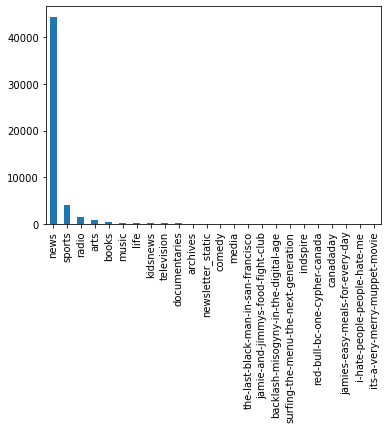

In [ ]:
df['first_segment'].value_counts().plot(kind='bar')
plt.show()

### Last segment, i.e., right before final slash

In [ ]:
df['last_segment'] = df['url'].str.extract(r'cbc\.ca/[^/]+/([^/]+)')

# Count occurrences of each unique second segment
last_segment_counts = df['last_segment'].value_counts()

# Display the counts
print("\nCounts for the last segment:\n", last_segment_counts)


Counts for the last segment:
 canada                                                                                                    38504
world                                                                                                      2054
politics                                                                                                   1694
olympics                                                                                                    918
hockey                                                                                                      882
                                                                                                          ...  
the-song-that-called-them-home-by-david-a-robertson-illustrated-by-maya-mckibbin-1.6816003                    1
the-buzzer-newsletter-marathon-goat-eliud-kpchoge-1.6815840                                                   1
sarah-polley-brandi-morin-saeed-teebi-shortlisted-for-10k-rakuten-kobo-em

In [ ]:
# Count occurrences of each unique last segment
last_segment_counts = df['last_segment'].value_counts()

# Calculate the total count
last_total_counts = last_segment_counts.sum()

print("\nTotal count across all last segments:", last_total_counts)


Total count across all last segments: 52313


Check that this count is the same as `n_all`

In [ ]:
n_all

52325

In [ ]:
last_segment_counts.to_csv('URL_last_segment.csv')

### Check whether all last segment stuff is just news

In [ ]:
# Filter the DataFrame where the first_segment is 'news'
news_df = df[df['first_segment'] == 'news']

# Count occurrences of the last_segment for the 'news' first segment
news_last_segment_counts = news_df['last_segment'].value_counts()

# Print the results
print("Counts of the last segment for 'news':\n", news_last_segment_counts)

Counts of the last segment for 'news':
 canada                                                   38504
world                                                     2054
politics                                                  1694
business                                                   648
entertainment                                              541
                                                         ...  
ukraine-russia-counteroffensive-summer-1.6895765             1
social-media-advertising-federal-government-1.6899347        1
wage-theft-ontario-workers-1.6913090                         1
hunter-biden-explainer-1.6928591                             1
israel-hamas-war-day-79-1.7069133                            1
Name: last_segment, Length: 77, dtype: int64


In [ ]:
# Count occurrences of each unique last segment after news
news_last_segment_counts = df['last_segment'].value_counts()

# Calculate the total count
news_last_total_counts = news_last_segment_counts.sum()

print("\nTotal count of news last segments:", news_last_total_counts)


Total count of news last segments: 52313


In [ ]:
news_last_segment_counts.to_csv('URL_news_last_segment.csv')

### Not sure the above works
Trying something else

In [ ]:
# Filter the DataFrame where the first_segment is 'news'
news_df = df[df['first_segment'] == 'news']

In [ ]:
news_df

,id,url,body,title,first_segment,last_segment
1,63b0d065f642cd4562ec7bd0,https://www.cbc.ca/news/world/north-korea-incr...,North Korean leader Kim Jong-un vowed to incre...,Kim Jong-un vows to 'exponentially' increase N...,news,world
2,63b0eb8bf642cd4562ed022d,https://www.cbc.ca/news/canada/british-columbi...,Starting Monday Translink will modify 45 bus r...,Translink is changing service on 45 bus routes...,news,canada
5,63b1167cf642cd4562ee1392,http://www.cbc.ca/news/canada/british-columbia...,Police in Victoria are looking for more potent...,Man arrested after Victoria assaults where wom...,news,canada
10,63b14edcf642cd4562efb0e7,https://www.cbc.ca/news/canada/toronto/bus-com...,"With the main competitor out of the way, bus c...",Is the bus back? Why these companies are betti...,news,canada
11,63b14edff642cd4562efb136,https://www.cbc.ca/news/canada/montreal/quebec...,Quebecers are increasingly streaming music onl...,Quebecers are listening to less local music; a...,news,canada
...,...,...,...,...,...,...
52318,6591d9f058b434ef00c268bb,https://www.cbc.ca/news/canada/prince-edward-i...,Edward Lambert remembers attending a New Year'...,Kensington café spreading the love with 'queer...,news,canada
52320,6591e7ed58b434ef00c2bf9c,https://www.cbc.ca/news/world/israel-siblings-...,Israeli Maya Regev lay badly wounded in a nond...,Israeli siblings freed from Hamas describe pas...,news,world
52322,6591f60658b434ef00c3239c,http://www.cbc.ca/news/world/israel-hamas-war-...,Israeli strikes in central Gaza killed at leas...,Israeli strikes in central Gaza kill at least ...,news,world
52323,6591f6b158b434ef00c32999,https://www.cbc.ca/news/canada/manitoba/jets-m...,Rutger McGroarty was desperate to play for his...,Jets prospect McGroarty savouring 2nd world ju...,news,canada


In [ ]:
news_df['news_type'] = news_df['url'].str.extract(r'cbc\.ca/news/([^/]+)')

# Count occurrences of each unique segment
news_counts = news_df['news_type'].value_counts()

# Display the counts
print("Counts for the first news segment:\n", news_df['news_type'].value_counts())

Counts for the first news segment:
 canada                                                   38504
world                                                     2054
politics                                                  1694
business                                                   648
entertainment                                              541
                                                         ...  
ukraine-russia-counteroffensive-summer-1.6895765             1
social-media-advertising-federal-government-1.6899347        1
wage-theft-ontario-workers-1.6913090                         1
hunter-biden-explainer-1.6928591                             1
israel-hamas-war-day-79-1.7069133                            1
Name: news_type, Length: 77, dtype: int64


C:\Users\mtaboada\AppData\Local\Temp/ipykernel_27320/242458718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['news_type'] = news_df['url'].str.extract(r'cbc\.ca/news/([^/]+)')


In [ ]:
news_counts

canada                                                   38504
world                                                     2054
politics                                                  1694
business                                                   648
entertainment                                              541
                                                         ...  
ukraine-russia-counteroffensive-summer-1.6895765             1
social-media-advertising-federal-government-1.6899347        1
wage-theft-ontario-workers-1.6913090                         1
hunter-biden-explainer-1.6928591                             1
israel-hamas-war-day-79-1.7069133                            1
Name: news_type, Length: 77, dtype: int64

In [ ]:
news_counts.to_csv('URL_news_types.csv')

### Further, what types under 'canada'

In [ ]:
news_df

,id,url,body,title,first_segment,last_segment,news_type
1,63b0d065f642cd4562ec7bd0,https://www.cbc.ca/news/world/north-korea-incr...,North Korean leader Kim Jong-un vowed to incre...,Kim Jong-un vows to 'exponentially' increase N...,news,world,world
2,63b0eb8bf642cd4562ed022d,https://www.cbc.ca/news/canada/british-columbi...,Starting Monday Translink will modify 45 bus r...,Translink is changing service on 45 bus routes...,news,canada,canada
5,63b1167cf642cd4562ee1392,http://www.cbc.ca/news/canada/british-columbia...,Police in Victoria are looking for more potent...,Man arrested after Victoria assaults where wom...,news,canada,canada
10,63b14edcf642cd4562efb0e7,https://www.cbc.ca/news/canada/toronto/bus-com...,"With the main competitor out of the way, bus c...",Is the bus back? Why these companies are betti...,news,canada,canada
11,63b14edff642cd4562efb136,https://www.cbc.ca/news/canada/montreal/quebec...,Quebecers are increasingly streaming music onl...,Quebecers are listening to less local music; a...,news,canada,canada
...,...,...,...,...,...,...,...
52318,6591d9f058b434ef00c268bb,https://www.cbc.ca/news/canada/prince-edward-i...,Edward Lambert remembers attending a New Year'...,Kensington café spreading the love with 'queer...,news,canada,canada
52320,6591e7ed58b434ef00c2bf9c,https://www.cbc.ca/news/world/israel-siblings-...,Israeli Maya Regev lay badly wounded in a nond...,Israeli siblings freed from Hamas describe pas...,news,world,world
52322,6591f60658b434ef00c3239c,http://www.cbc.ca/news/world/israel-hamas-war-...,Israeli strikes in central Gaza killed at leas...,Israeli strikes in central Gaza kill at least ...,news,world,world
52323,6591f6b158b434ef00c32999,https://www.cbc.ca/news/canada/manitoba/jets-m...,Rutger McGroarty was desperate to play for his...,Jets prospect McGroarty savouring 2nd world ju...,news,canada,canada


In [ ]:
news_canada_df = news_df[news_df['news_type'] == 'canada']

In [ ]:
news_canada_df['news_canada_type'] = news_canada_df['url'].str.extract(r'cbc\.ca/news/canada/([^/]+)')

# Count occurrences of each unique segment
news_canada_counts = news_canada_df['news_canada_type'].value_counts()

# Display the counts
print("Counts for the first news canada segment:\n", news_canada_df['news_canada_type'].value_counts())

Counts for the first news canada segment:
 british-columbia                                                                                  3920
manitoba                                                                                          3542
nova-scotia                                                                                       2864
toronto                                                                                           2502
ottawa                                                                                            2391
                                                                                                  ... 
am-i-still-a-mother-if-my-newborn-died-1.6822059                                                     1
our-baby-girls-were-born-5-months-apart-after-we-suffered-with-infertility-for-years-1.6822095       1
stanley-cup-canada-chart-1.6820519                                                                   1
king-charles-coronation-viewin

C:\Users\mtaboada\AppData\Local\Temp/ipykernel_27320/4269701876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_canada_df['news_canada_type'] = news_canada_df['url'].str.extract(r'cbc\.ca/news/canada/([^/]+)')


In [ ]:
news_canada_counts.to_csv('URL_news_canada.csv')

### Just checking what's under PEI, the province with the smallest number of articles

In [ ]:
news_pei_df = news_canada_df[news_canada_df['news_canada_type'] == 'prince-edward-island']

In [ ]:
news_pei_df

,id,url,body,title,first_segment,last_segment,news_type,news_canada_type
41,63b1d4a0f642cd4562f31f0e,https://www.cbc.ca/news/canada/prince-edward-i...,Haley Zavo always dreamed of creating a vibran...,Kings Playhouse executive director exits stage...,news,canada,canada,prince-edward-island
82,63b2ae78f642cd4562f87fc6,https://www.cbc.ca/news/canada/prince-edward-i...,Canadian Blood Services is urging people on Pr...,Canadian Blood Services urges Islanders to boo...,news,canada,canada,prince-edward-island
90,63b2c3aef642cd4562f933e3,https://www.cbc.ca/news/canada/prince-edward-i...,"The police cruiser, a century-old symbol of po...","Cruisers out, SUVs in as Charlottetown renews ...",news,canada,canada,prince-edward-island
104,63b30298f642cd4562fad8a9,https://www.cbc.ca/news/canada/prince-edward-i...,It's been a long year for Buddy the eagle at C...,"Eagle, recovered from spinal surgery, heading ...",news,canada,canada,prince-edward-island
152,63b36492f642cd4562fd297a,https://www.cbc.ca/news/canada/prince-edward-i...,Some members of P.E.I.'s Chinese community hav...,"As China eases COVID-19 restrictions, some peo...",news,canada,canada,prince-edward-island
...,...,...,...,...,...,...,...,...
52241,6590334558b434ef00b69058,https://www.cbc.ca/news/canada/prince-edward-i...,The emergency department at Western Hospital i...,"Alberton ER closed for weekend, other hospital...",news,canada,canada,prince-edward-island
52284,65913e9658b434ef00be0a3a,https://www.cbc.ca/news/canada/prince-edward-i...,Many P.E.I. businesses and services will be cl...,New Year's Eve and New Year's Day: What's open...,news,canada,canada,prince-edward-island
52286,65913f1358b434ef00be0fd2,https://www.cbc.ca/news/canada/prince-edward-i...,A provincial election. A scathing report detai...,A look back at the stories that shaped Prince ...,news,canada,canada,prince-edward-island
52300,659199ab58b434ef00c0a0e4,https://www.cbc.ca/news/canada/prince-edward-i...,Tennis P.E.I. is searching for a new home cour...,"After 43 years, it's game, set, match for tenn...",news,canada,canada,prince-edward-island


In [ ]:
news_pei_df.to_csv('URL_news_pei.csv')